<a href="https://colab.research.google.com/github/williambiondi/RecommenderGS/blob/main/recommenderGranSasso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importazione dei dati e librerie


In [1]:
!pip install tensorflow -q
!pip install transformers -q
!pip install tensorflow-recommenders -q
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from transformers import DistilBertTokenizer, TFDistilBertModel
from IPython import display
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import re
from keras_tuner import HyperModel
from kerastuner.tuners import RandomSearch


<ipython-input-2-ea52cb71ca94>:11: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


#Caricamento dati

In [3]:
items = pd.read_csv('ArticoliGransasso.csv')
customers = pd.read_csv('ClientiGransasso.csv')
purchases = pd.read_csv('OrdiniGransasso.csv')

items.drop(columns=['Unnamed: 0'], inplace=True)
customers.drop(columns=['Unnamed: 0'], inplace=True)
purchases.drop(columns=['Unnamed: 0'], inplace=True)

#Preparazione dati per modello


ricavo le fasce di prezzo

In [4]:
bins = list(range(0, int(items['UnitPrice'].max()) + 150, 150))
items['PriceRange'] = pd.cut(items['UnitPrice'], bins = bins, right=False).astype(str)

Annoto come interazione positiva (1) tutti gli articoli acquistati, come interazione negativa (-1) tutti gli articoli rimborsati

In [5]:
interactions = [1 if row['RefundedEUR'] == 0 else -1 for _,row in purchases.iterrows()]
purchases["Interaction"] = interactions

In [6]:
text_combined = []
for idx, row in items.iterrows():
  descriptive = row['ItemName'].lower()+" "+row['Description']
  text_combined.append(descriptive)
items['TextInfo'] = text_combined

In [7]:
len_desc = [len(row['TextInfo'].split(" ")) for _,row in items.iterrows()]
max(len_desc)

190

Utilizzo DistilBERT per ottenere gli embeddings di tutta l'informazione testuale degli articoli (nome articolo e descrizione)

In [8]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
enc_input = tokenizer(items['TextInfo'].tolist(),
                      padding=True,
                      truncation=True,
                      max_length=150,
                      return_tensors='tf')

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [9]:
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [10]:
outputs = distilbert_model(enc_input)
embeddings = outputs.last_hidden_state

In [11]:
embeddings_np = embeddings.numpy()
summary_embeddings = embeddings_np[:,0,:]
df_embeddings = pd.DataFrame(summary_embeddings)
df_embeddings.columns = [f'embedding_{i}' for i in range(df_embeddings.shape[1])]

In [12]:
df_embeddings.head()

,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,embedding_9,...,embedding_758,embedding_759,embedding_760,embedding_761,embedding_762,embedding_763,embedding_764,embedding_765,embedding_766,embedding_767
0,-0.152692,-0.702594,0.226575,-0.092627,0.150878,-0.052346,0.132293,0.289687,-0.130670,-0.294651,...,-0.045851,-0.592887,0.098132,-0.310700,0.045292,-0.331142,-0.110403,-0.167462,0.064619,-0.084191
1,-0.183465,-0.758047,0.025607,-0.106878,0.167659,-0.116863,0.084983,0.325271,0.031011,-0.256441,...,-0.039702,-0.501641,0.018874,-0.313824,0.023122,-0.488100,-0.089355,-0.199527,0.250173,-0.131352
2,-0.235758,-0.616278,0.186698,-0.050992,0.163522,-0.045681,0.081499,0.254824,-0.088808,-0.285371,...,0.009386,-0.555698,0.095906,-0.385060,-0.018019,-0.202692,-0.129432,-0.250053,0.047502,-0.117530
3,-0.080283,-0.587356,0.281823,-0.119877,0.063588,-0.044179,0.075656,0.288735,-0.159558,-0.265397,...,0.126247,-0.505958,0.169416,-0.327713,0.025114,-0.154299,-0.163061,-0.110773,0.150633,0.053784
4,-0.136119,-0.455885,0.220127,-0.032341,0.044970,-0.166100,0.079893,0.324760,-0.202329,-0.267275,...,-0.074009,-0.526028,0.137117,-0.344637,-0.017099,-0.273234,-0.202651,-0.110191,0.116088,0.078281


Riduco gli embeddings

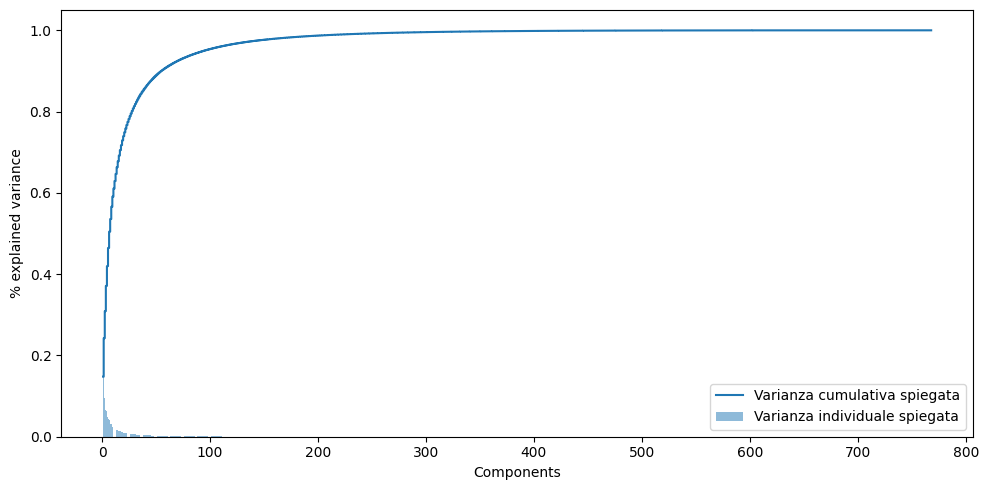

In [13]:
pca = PCA()
pca.fit(df_embeddings)

explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

n_components = np.where(cumulative>=0.95)[0][0]+1

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(explained) + 1), explained, alpha=0.5, align='center', label='Varianza individuale spiegata')
plt.step(range(1, len(cumulative) + 1), cumulative, where='mid', label='Varianza cumulativa spiegata')
plt.ylabel('% explained variance')
plt.xlabel('Components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [14]:
pca = PCA(n_components=n_components)
reduced = pca.fit_transform(df_embeddings)
df_reduced = pd.DataFrame(reduced, columns = [f"pc_{i}" for i in range(reduced.shape[1])])

In [15]:
df_reduced['ItemId'] = items['ItemId']

In [16]:
df_reduced.head()

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,pc_9,...,pc_86,pc_87,pc_88,pc_89,pc_90,pc_91,pc_92,pc_93,pc_94,ItemId
0,0.432963,-0.214803,-0.676672,0.242813,-0.502656,0.213210,0.044396,-0.406401,0.119942,0.290807,...,0.075785,-0.019075,0.038558,0.042725,0.028860,0.100750,0.064020,0.019439,0.054300,0
1,-1.344924,-0.502457,-0.108876,-0.200828,-0.811728,-0.145808,-0.138468,-0.102818,0.132491,-0.286622,...,-0.047473,-0.035098,-0.138641,0.061011,0.154272,0.013630,-0.003689,0.096888,0.095366,1
2,-0.508015,0.428693,-0.924211,-0.456849,-0.142502,-0.227784,0.160293,0.145658,-0.215664,-0.172426,...,0.052420,-0.125140,0.073854,-0.141572,0.047388,-0.032435,0.064607,-0.012119,-0.139100,2
3,0.467723,0.633644,-0.853466,0.216091,-0.056631,-0.370799,-0.207275,0.360089,0.606439,0.535525,...,0.160344,0.045842,-0.082091,0.168626,0.189597,-0.021261,0.017328,0.040824,0.099642,3
4,1.449940,0.353151,-0.104017,-0.192969,-0.214783,-0.368196,-0.541564,0.426436,0.140479,0.117264,...,0.113184,0.052751,-0.075899,0.004606,-0.018509,0.021279,0.090715,0.011003,-0.005483,4


In [17]:
full_items = items.merge(df_reduced, on='ItemId')

In [18]:
df_full = full_items.merge(purchases, on='ItemId')

In [19]:
df_full.head()

,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,...,pc_91,pc_92,pc_93,pc_94,Id,UserId,CreatedOnUtc,RefundedEUR,UnitPriceTaxEUR,Interaction
0,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,0.10075,0.064020,0.019439,0.054300,8812,0,2021-01-01 09:29:05.2513839,0.0,130.0,1
1,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,0.10075,0.064020,0.019439,0.054300,8860,47,2021-01-03 23:11:34.9635880,0.0,130.0,1
2,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,0.10075,0.064020,0.019439,0.054300,9311,413,2021-02-13 12:39:33.7391675,0.0,130.0,1
3,A20205716614238589,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.0,0,Fall-Winter,0,589,Men,crew neck sweater in pure merino wool with mic...,...,0.10075,0.064020,0.019439,0.054300,9772,276,2021-04-10 11:33:22.9952881,0.0,130.0,1
4,A20201312414230005,WAVE PATTERN TURTLENECK,['Maglieria'],160.0,1,Fall-Winter,0,5,Men,turtleneck sweater in pure merino wool embelli...,...,0.01363,-0.003689,0.096888,0.095366,8813,1,2021-01-01 09:39:57.3829465,0.0,160.0,1


#Training

In [20]:
data_tf = tf.data.Dataset.from_tensor_slices({
    "user_id": df_full['UserId'].values.reshape(-1,1),
    "item_id": df_full['ItemId'].values.reshape(-1,1),
    "item_embedding" : df_full[[f'pc_{i}' for i in range(reduced.shape[1])]].values
})

In [21]:
candidates_tf = tf.data.Dataset.from_tensor_slices({
    "item_id": full_items['ItemId'].values.reshape(-1,1),
    "item_embedding" : full_items[[f'pc_{i}' for i in range(reduced.shape[1])]].values
})
candidates_ds = candidates_tf.batch(32)

Divido in train e test

In [22]:
data_tf = data_tf.shuffle(buffer_size=1024, seed = 999, reshuffle_each_iteration = False)
full_size = len(data_tf)
train_size = int(full_size * 0.8)
val_size = int(train_size * 0.2)
train_size -= val_size

train = data_tf.take(train_size)
rest = data_tf.skip(train_size)
val = rest.take(val_size)
test = rest.skip(val_size)

In [23]:
batch_size = 32
train = train.shuffle(buffer_size=1024, seed = 999).batch(batch_size)
test = test.batch(batch_size)
val = val.batch(batch_size)

In [24]:
for features in train.take(1):
    print("User ID Shape in Train:", features["user_id"].shape)
    print("Item Embedding Shape in Train:", features["item_embedding"].shape)

User ID Shape in Train: (32, 1)
Item Embedding Shape in Train: (32, 95)


In [25]:
class CFRecommender(tfrs.Model):

  def __init__(self, user_model, item_model, candidates):
    super().__init__()
    self.user_model = user_model
    self.item_model = item_model
    self.task = tfrs.tasks.Retrieval(metrics=tfrs.metrics.FactorizedTopK(
            candidates = candidates.map(self.item_model)))

  def compute_loss(self, features, training = False):
    user_emb = self.user_model(features['user_id'])
    item_emb = self.item_model(features['item_embedding'])
    return self.task(user_emb, item_emb)

In [26]:
unique_user_ids = df_full['UserId'].unique().astype(str)
unique_item_ids = df_full['ItemId'].unique().astype(str)
embedding_dim = n_components

user_model = tf.keras.Sequential([
                                  tf.keras.layers.Embedding(input_dim = len(unique_user_ids), output_dim = embedding_dim),
                                  tf.keras.layers.Flatten()
                                  ])

item_model = tf.keras.Sequential([tf.keras.Input(shape=(embedding_dim,), dtype=tf.float32, name='item_embedding'),
                                  tf.keras.layers.Dense(embedding_dim)
                                ])

In [36]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model',
    save_best_only=True,
    monitor='val_loss',
    mode='min')

In [37]:
initial_learning_rate = 0.4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True)

optimizer = tf.keras.optimizers.Adagrad(learning_rate=lr_schedule)

In [38]:
recommender = CFRecommender(user_model, item_model, candidates_ds)
recommender.compile(optimizer = optimizer)

/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [39]:
recommender.fit(train,
                validation_data = val,
                epochs=100,
                callbacks=[early_stop])

Epoch 1/100
398/398 [==============================] - 44s 108ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0290 - factorized_top_k/top_5_categorical_accuracy: 0.0377 - factorized_top_k/top_10_categorical_accuracy: 0.0456 - factorized_top_k/top_50_categorical_accuracy: 0.1058 - factorized_top_k/top_100_categorical_accuracy: 0.1488 - loss: 138.1417 - regularization_loss: 0.0000e+00 - total_loss: 138.1417 - val_factorized_top_k/top_1_categorical_accuracy: 0.0132 - val_factorized_top_k/top_5_categorical_accuracy: 0.0349 - val_factorized_top_k/top_10_categorical_accuracy: 0.0459 - val_factorized_top_k/top_50_categorical_accuracy: 0.0991 - val_factorized_top_k/top_100_categorical_accuracy: 0.1305 - val_loss: 28.9579 - val_regularization_loss: 0.0000e+00 - val_total_loss: 28.9579
Epoch 2/100
398/398 [==============================] - 42s 106ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1160 - factorized_top_k/top_5_categorical_accuracy: 0.1571 - factorized_top_k/top_10_

In [28]:
recommender.evaluate(test)

125/125 [==============================] - 9s 68ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0564 - factorized_top_k/top_5_categorical_accuracy: 0.0969 - factorized_top_k/top_10_categorical_accuracy: 0.1283 - factorized_top_k/top_50_categorical_accuracy: 0.2619 - factorized_top_k/top_100_categorical_accuracy: 0.3298 - loss: 129.8241 - regularization_loss: 0.0000e+00 - total_loss: 129.8241


[0.05635220184922218,
 0.09685534238815308,
 0.12830188870429993,
 0.2618868052959442,
 0.32981133460998535,
 20.26055908203125,
 0,
 20.26055908203125]

#Tuning dei parametri

In [27]:
class HyperRecommender(HyperModel):
  def __init__(self, user_input_dim, item_input_dim, embedding_dim, candidates_ds):
    self.user_input_dim = user_input_dim
    self.item_input_dim = item_input_dim
    self.embedding_dim = embedding_dim
    self.candidates_ds = candidates_ds

  def build(self, hp):
    user_model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=self.user_input_dim, output_dim=self.embedding_dim),
        tf.keras.layers.Flatten()
    ])
    # Item model
    item_model = tf.keras.Sequential([
        tf.keras.Input(shape=(self.item_input_dim,), dtype=tf.float32, name='item_embedding'),
        tf.keras.layers.Dense(units=embedding_dim, activation='relu')
    ])

    # Define the CFRecommender model
    model = CFRecommender(user_model, item_model, self.candidates_ds)

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adagrad(learning_rate=hp.Float('learning_rate', min_value=1e-2, max_value=6e-1, sampling='LOG')),
    )

    return model

In [28]:
hypermodel = HyperRecommender(user_input_dim=len(unique_user_ids),
                              item_input_dim=embedding_dim,
                              embedding_dim=embedding_dim,
                              candidates_ds=candidates_ds)


In [31]:
tuner = RandomSearch(hypermodel,
                     objective = 'val_loss',
                     max_trials = 40,
                     directory = 'keras_tuner_dir',
                     project_name = 'gs_recommender')

In [32]:
tuner.search_space_summary()
tuner.search(train, validation_data=val, epochs=20, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Trial 40 Complete [00h 02m 25s]
val_loss: 24.556163787841797

Best val_loss So Far: 22.793617248535156
Total elapsed time: 01h 48m 28s


In [33]:
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparams)

In [34]:
best_model = tuner.hypermodel.build(best_hyperparams)
best_model.fit(train, validation_data=val, epochs=100)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/engine/functional.py:639: UserWarning: Input dict contained keys ['item_id'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


398/398 [==============================] - 37s 91ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0127 - factorized_top_k/top_5_categorical_accuracy: 0.0163 - factorized_top_k/top_10_categorical_accuracy: 0.0223 - factorized_top_k/top_50_categorical_accuracy: 0.0922 - factorized_top_k/top_100_categorical_accuracy: 0.1465 - loss: 104.3669 - regularization_loss: 0.0000e+00 - total_loss: 104.3669 - val_factorized_top_k/top_1_categorical_accuracy: 0.0154 - val_factorized_top_k/top_5_categorical_accuracy: 0.0337 - val_factorized_top_k/top_10_categorical_accuracy: 0.0409 - val_factorized_top_k/top_50_categorical_accuracy: 0.0862 - val_factorized_top_k/top_100_categorical_accuracy: 0.1280 - val_loss: 23.2002 - val_regularization_loss: 0.0000e+00 - val_total_loss: 23.2002
Epoch 2/100
398/398 [==============================] - 36s 90ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0603 - factorized_top_k/top_5_categorical_accuracy: 0.0822 - factorized_top_k/top_10_categorical_ac

In [35]:
best_model.evaluate(test )

125/125 [==============================] - 10s 79ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0091 - factorized_top_k/top_5_categorical_accuracy: 0.0189 - factorized_top_k/top_10_categorical_accuracy: 0.0239 - factorized_top_k/top_50_categorical_accuracy: 0.0591 - factorized_top_k/top_100_categorical_accuracy: 0.0865 - loss: 181.7553 - regularization_loss: 0.0000e+00 - total_loss: 181.7553


[0.009056603536009789,
 0.01886792480945587,
 0.023899370804429054,
 0.05911949649453163,
 0.08654087781906128,
 12.405641555786133,
 0,
 12.405641555786133]

#Raccomandazioni per utente e per articolo

In [29]:
candidates_embeddings = item_model.predict(df_reduced.values[:, :-1])
candidate_item_ids = full_items['ItemId'].values

110/110 [==============================] - 0s 971us/step


In [30]:
def user_recommendations(user_id, user_model, item_model, candidates,candidates_ids, k=5):
  user_id_tensor = tf.convert_to_tensor([[user_id]])
  user_embedding = user_model(user_id_tensor)
  scores = tf.matmul(user_embedding, candidates, transpose_b=True)
  top_k_indices = tf.math.top_k(scores, k=k).indices.numpy().flatten()
  return [candidates_ids[i] for i in top_k_indices]

In [31]:
uid = customers[customers['CustomerId']== 91311]['UserId']
recommendation_ids = user_recommendations(uid.iloc[0], user_model, item_model, candidates_embeddings, candidate_item_ids,3)
items[items['ItemId'].isin(recommendation_ids)]

,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,Composition,PriceRange,TextInfo
360,P20215516718190099,COTTON CREW NECK,['Maglieria'],150.31,360,Spring-Summer,0,99,Men,pure cotton crew neck an essential every man s...,cotton,"[150, 300)",cotton crew neck pure cotton crew neck an es...
373,P20215516718190598,COTTON CREW NECK,['Maglieria'],125.00,373,Spring-Summer,0,598,Men,pure cotton crew neck an essential every man s...,cotton,"[0, 150)",cotton crew neck pure cotton crew neck an es...
382,P20215516718190485,COTTON CREW NECK,['Maglieria'],125.00,382,Spring-Summer,0,485,Men,pure cotton crew neck an essential every man s...,cotton,"[0, 150)",cotton crew neck pure cotton crew neck an es...


In [32]:
def similar_items(item_id, item_model, candidates_embeddings,candidates_ids, k=5):
  input = df_reduced.iloc[item_id].values[:95].reshape(1, -1)
  item_embedding = item_model.predict(input)
  scores = tf.matmul(item_embedding, candidates_embeddings.T)
  top_k_indices = tf.math.top_k(scores, k=k+1).indices.numpy().flatten()
  top_k_indices = top_k_indices[top_k_indices != item_id]
  return [candidates_ids[i] for i in top_k_indices[:k]]

In [33]:
item_id = 0
similar_to = similar_items(item_id, item_model, candidates_embeddings, candidate_item_ids, k=5)
items[items['ItemId'].isin(similar_to)]

1/1 [==============================] - 0s 20ms/step


,Sku,ItemName,Category,UnitPrice,ItemId,Collection,Availability,Color,Gender,Description,Composition,PriceRange,TextInfo
209,A20202325320353200,CASHMERE MOCK WITH VANISE' PROFILES,['Maglieria'],192.62,209,Fall-Winter,0,200,Women,2ply mock sweater in pure merino wool the neck...,wool,"[150, 300)",cashmere mock with vanise' profiles 2ply mock ...
284,A20205716614238598,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.00,284,Fall-Winter,0,598,Men,crew neck sweater in pure merino wool with mic...,wool,"[0, 150)",micro rhombus stitch crew neck crew neck sweat...
286,A20205716614238291,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.00,286,Fall-Winter,0,291,Men,crew neck sweater in pure merino wool with mic...,wool,"[0, 150)",micro rhombus stitch crew neck crew neck sweat...
339,A20202318414240291,HERRINGBONE DOUBLE-BREASTED KNIT JACKET,"['Maglieria', 'Capispalla', 'Giacche']",395.00,339,Fall-Winter,0,291,Men,herringbone doublebreasted knit jacket in pure...,wool,"[300, 450)",herringbone double-breasted knit jacket herrin...
621,A20205716614238005,MICRO RHOMBUS STITCH CREW NECK,['Maglieria'],130.00,621,Fall-Winter,0,5,Men,crew neck sweater in pure merino wool with mic...,wool,"[0, 150)",micro rhombus stitch crew neck crew neck sweat...
